In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import scipy.optimize as spo
plt.style.use('seaborn')

#### Unimportant Warnings

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

#### Custom Files

In [3]:
from data_io import DataIO # Custom IO file

# Input/Output of RGA and Temperature Data

In [4]:
Path = os.getcwd() + "/data/2020_11_09/" # data file path

In [5]:
IO = DataIO(Path)

In [6]:
IO.Unzip()

In [7]:
RGA_Data = IO.GetRGAData()

In [8]:
Temp = IO.GetTemperatureData()

In [9]:
#data.to_hdf(p+"10_19_rga_2020.h5", key='data')

In [10]:
RGA_Data

,Datetime,Mass,Pressure
0,2020-11-09 16:59:53,1,1.93e-09
1,2020-11-09 16:59:53,1.1,3.31e-09
2,2020-11-09 16:59:53,1.2,6.48e-08
3,2020-11-09 16:59:53,1.3,2.31e-07
4,2020-11-09 16:59:53,1.4,4.75e-08
...,...,...,...
5517883,2020-11-12 00:59:28,99.6,-1.68e-10
5517884,2020-11-12 00:59:28,99.7,-1.09e-10
5517885,2020-11-12 00:59:28,99.8,-9.69e-11
5517886,2020-11-12 00:59:28,99.9,-9.48e-11


In [11]:
Temp

,Date,Time,CH1,CH2,Datetime
0,11/10/2020,1:19:00,20.3,20.2,2020-11-10 01:19:00
1,11/10/2020,1:19:01,20.3,20.3,2020-11-10 01:19:01
2,11/10/2020,1:19:02,20.3,20.3,2020-11-10 01:19:02
3,11/10/2020,1:19:03,20.3,20.3,2020-11-10 01:19:03
4,11/10/2020,1:19:04,20.3,20.3,2020-11-10 01:19:04
...,...,...,...,...,...
189796,11/12/2020,9:34:07,20.4,20.3,2020-11-12 09:34:07
189797,11/12/2020,9:34:08,20.4,20.3,2020-11-12 09:34:08
189798,11/12/2020,9:34:09,20.4,20.3,2020-11-12 09:34:09
189799,11/12/2020,9:34:10,20.4,20.3,2020-11-12 09:34:10


### Times

In [12]:
# Starting RGA Time.
rga_start = RGA_Data['Datetime'].sort_values().unique()[0]

In [13]:
# Starting temperature time.
temps_start = Temp['Datetime'].sort_values().unique()[0]

In [14]:
# Find the EARLIEST time to calculate timedeltas from.
if rga_start < temps_start:
    start_datetime = rga_start
else:
    start_datetime = temps_start

In [15]:
start_datetime

numpy.datetime64('2020-11-09T16:59:53.000000000')

In [16]:
temp_times = (Temp['Datetime'] - start_datetime)/np.timedelta64(1, 's')

In [17]:
# Separate by mass
H2_data = RGA_Data[RGA_Data['Mass'] == 2.0]
H2O_data = RGA_Data[RGA_Data['Mass'] == 18.0]
N2_data = RGA_Data[RGA_Data['Mass'] == 28.0]
O2_data = RGA_Data[RGA_Data['Mass'] == 32.0]
CO2_data = RGA_Data[RGA_Data['Mass'] == 44.0]

In [18]:
rga_times = (RGA_Data['Datetime'].unique() - start_datetime)/np.timedelta64(1, 's')
H2_times = (H2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
H2O_times = (H2O_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
N2_times = (N2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
O2_times = (O2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')
CO2_times = (CO2_data['Datetime'] - start_datetime)/np.timedelta64(1, 's')

### Temperature Interpolation

In [19]:
CO2_ch1_lerp = np.interp(CO2_times, temp_times, pd.to_numeric(Temp['CH1']))
CO2_ch2_lerp = np.interp(CO2_times, temp_times, pd.to_numeric(Temp['CH2']))

### Final Data Frames

In [20]:
## Build O2 final data frame
CO2_final_data = pd.DataFrame(data=CO2_times)
CO2_final_data.columns = ['Exp_Time']
# Microtorr now
CO2_final_data['CO2_Pressure'] = CO2_data['Pressure']
# Celsius to Kelvin
CO2_final_data['ch1_lerp'] = CO2_ch1_lerp + 273.2
CO2_final_data['ch2_lerp'] = CO2_ch2_lerp + 273.2
CO2_final_data['temp_est'] = (CO2_final_data['ch1_lerp'] + CO2_final_data['ch2_lerp'])/2.0
CO2_final_data

,Exp_Time,CO2_Pressure,ch1_lerp,ch2_lerp,temp_est
430,0.0,7.66e-07,293.5,293.4,293.45
1421,41.0,7.64e-07,293.5,293.4,293.45
2412,83.0,7.72e-07,293.5,293.4,293.45
3403,124.0,7.78e-07,293.5,293.4,293.45
4394,166.0,7.9e-07,293.5,293.4,293.45
...,...,...,...,...,...
5513363,201409.0,1.6e-08,293.7,293.5,293.60
5514354,201451.0,1.62e-08,293.7,293.5,293.60
5515345,201492.0,1.63e-08,293.7,293.5,293.60
5516336,201534.0,1.64e-08,293.7,293.5,293.60


In [21]:
CO2_final_data.sort_values(by='Exp_Time', inplace=True)

### Curve Fitting
$$p(t,T) = A\cdot \exp\left(-\frac{b}{T}\right)\cdot\exp\left(-c\cdot t\cdot \exp\left(-\frac{b}{T}\right)\right)$$

In [22]:
def pressure_fit(tT, A, b, c):
    # (k,M) array if there are k predictors
    factor = np.exp(-1.0*b/tT[1])
    return A * factor * np.exp(-1.0*c*tT[0]*factor)

In [23]:
#O2_jump1 = O2_final_data[O2_final_data['Datetime'].between(51000, 65000)]

In [24]:
#O2_Tdata = O2_jump1[['Datetime', 'temp_est']].T.to_numpy()
#O2_Tdata.shape

In [25]:
# Initial guess of uncertainties
#O2_sigma = np.empty(O2_Tdata.shape[1]); O2_sigma.fill(1e-9)
#O2_sigma.shape

In [26]:
#popt, pcov = spo.curve_fit(pressure_fit, O2_Tdata, O2_jump1['O2_Pressure'], p0=[50, 5800, 980], bounds=([-np.inf, -np.inf, 0],np.inf), maxfev=8000)

In [27]:
#popt

In [28]:
#pcov

In [29]:
#fit_vals = pressure_fit(O2_Tdata, popt[0], popt[1], popt[2])
#fit_vals

In [30]:
CO2_jump4 = CO2_final_data[CO2_final_data['Exp_Time'].between(111000, 150000)]
CO2_jump4

,Exp_Time,CO2_Pressure,ch1_lerp,ch2_lerp,temp_est
2468020,111006.0,1.04e-07,321.3,328.7,325.00
2470002,111048.0,1.04e-07,321.4,328.8,325.10
2471984,111089.0,1.04e-07,321.6,328.9,325.25
2473966,111131.0,1.06e-07,321.7,329.0,325.35
2475948,111172.0,1.05e-07,321.8,329.1,325.45
...,...,...,...,...,...
4323172,149804.0,7.21e-08,328.3,331.0,329.65
4325154,149845.0,7.22e-08,328.4,331.0,329.70
4327136,149887.0,7.26e-08,328.3,331.0,329.65
4329118,149928.0,7.21e-08,328.3,331.0,329.65


In [31]:
CO2_4T_start = CO2_jump4['Exp_Time'].unique()[0]
CO2_4T_start

111006.0

In [32]:
CO2_jump4['Jump_Time'] = CO2_jump4['Exp_Time'] - CO2_4T_start
CO2_jump4

<ipython-input-32-ae88c0a793ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CO2_jump4['Jump_Time'] = CO2_jump4['Exp_Time'] - CO2_4T_start


,Exp_Time,CO2_Pressure,ch1_lerp,ch2_lerp,temp_est,Jump_Time
2468020,111006.0,1.04e-07,321.3,328.7,325.00,0.0
2470002,111048.0,1.04e-07,321.4,328.8,325.10,42.0
2471984,111089.0,1.04e-07,321.6,328.9,325.25,83.0
2473966,111131.0,1.06e-07,321.7,329.0,325.35,125.0
2475948,111172.0,1.05e-07,321.8,329.1,325.45,166.0
...,...,...,...,...,...,...
4323172,149804.0,7.21e-08,328.3,331.0,329.65,38798.0
4325154,149845.0,7.22e-08,328.4,331.0,329.70,38839.0
4327136,149887.0,7.26e-08,328.3,331.0,329.65,38881.0
4329118,149928.0,7.21e-08,328.3,331.0,329.65,38922.0


In [33]:
CO2_4T = CO2_jump4[['Jump_Time', 'temp_est']].T.to_numpy()
CO2_4T.shape

(2, 941)

In [34]:
popt, pcov = spo.curve_fit(pressure_fit, CO2_4T, CO2_jump4['CO2_Pressure'], p0=[5.65, 5800, 650], bounds=([0, 0, 0],np.inf), maxfev=100000)

In [35]:
popt

array([5.65e+00, 5.80e+03, 6.50e+02])

In [36]:
pcov

array([[1.60475268e+00, 9.33465883e+01, 1.85557507e+02],
       [9.33465883e+01, 5.42992551e+03, 1.07934284e+04],
       [1.85557507e+02, 1.07934284e+04, 2.14577823e+04]])

In [37]:
CO2_4_fits = pressure_fit(CO2_4T, popt[0], popt[1], popt[2])

### Plotting

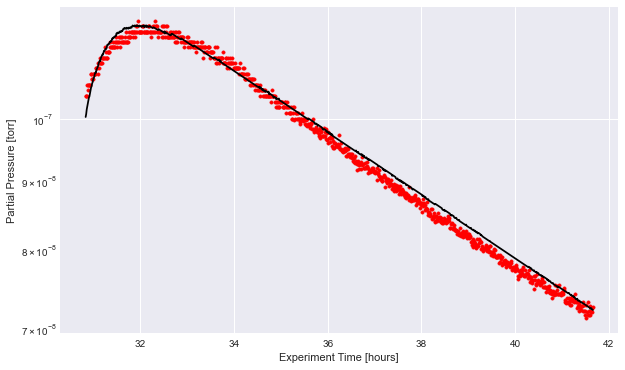

In [38]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(CO2_jump4['Exp_Time']/3600, CO2_jump4['CO2_Pressure'], marker='.', color='red')
ax.plot(CO2_jump4['Exp_Time']/3600, CO2_4_fits, color='black')
ax.set_ylabel('Partial Pressure [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.set_yscale('log')

plt.show()

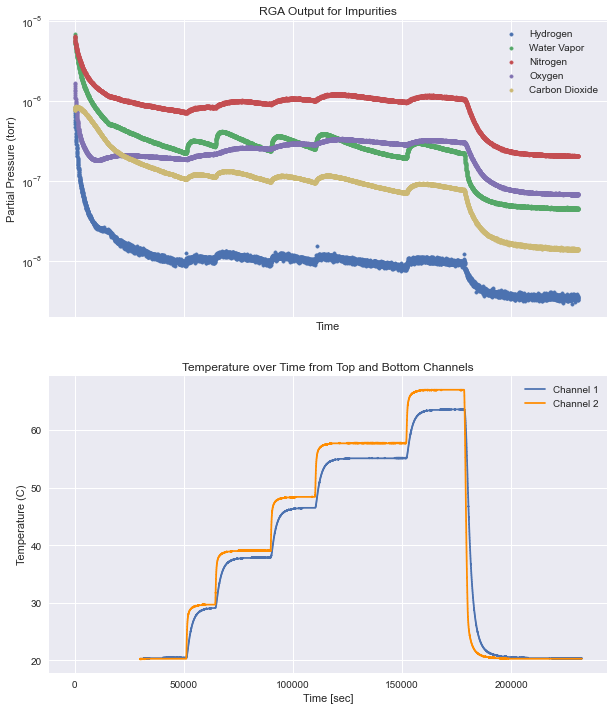

In [39]:
fig, ax = plt.subplots(figsize=(10,12),  nrows = 2, sharex=True)
ax[0].scatter(H2_times, H2_data['Pressure'], marker='.', label='Hydrogen')
ax[0].scatter(H2O_times, H2O_data['Pressure'], marker='.', label='Water Vapor')
ax[0].scatter(N2_times, N2_data['Pressure'], marker='.', label='Nitrogen')
ax[0].scatter(O2_times, O2_data['Pressure'], marker='.', label='Oxygen')
ax[0].scatter(CO2_times, CO2_data['Pressure'], marker='.', label='Carbon Dioxide')
ax[0].set_title('RGA Output for Impurities')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Partial Pressure (torr)')
ax[0].legend()
ax[0].set_yscale('log')

ax[1].plot(temp_times, pd.to_numeric(Temp['CH1']), label='Channel 1')
ax[1].plot(temp_times, pd.to_numeric(Temp['CH2']), label='Channel 2', color='darkorange')
ax[1].set_title('Temperature over Time from Top and Bottom Channels')
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel('Temperature (C)')
ax[1].legend()

fig.savefig('plot_out_2020_11_09.png', dpi=300)
plt.show()

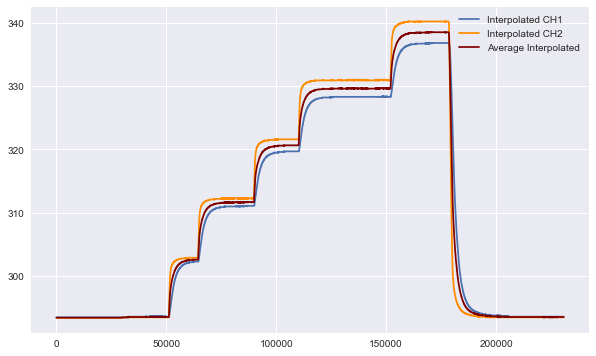

In [42]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(CO2_final_data['Exp_Time'], CO2_final_data['ch1_lerp'], label='Interpolated CH1')
ax.plot(CO2_final_data['Exp_Time'], CO2_final_data['ch2_lerp'], label='Interpolated CH2', color='darkorange')
ax.plot(CO2_final_data['Exp_Time'], CO2_final_data['temp_est'], label='Average Interpolated', color='maroon')
ax.legend()

plt.show()